In [1]:
#hide
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
from collections import defaultdict
from utils import *

In [2]:
real_hidden = pkl.load(open('../Data/parsed_data.pkl', 'rb'))
np.random.seed(42)
sim_name = 'debiasing_sim'
num_trials = 100

tau_a1 = 0.8
tau_a2 = 0.4
max_soc_util = calc_max_soc_util(tau_a1, tau_a2)
avg_ava = 0.39
res_dict = defaultdict(list)

for i_poll in range(len(real_hidden)):
    if (np.all((real_hidden[i_poll]['votes'].values) != None)) and (real_hidden[i_poll]['metadata']['opt2'] == 'yesno'):
        hidden_poll = real_hidden[i_poll]['votes'].values.astype(int)
        num_voters, num_ts = hidden_poll.shape
        if num_voters > 2 and num_ts > 2:
            for trial_num in range(num_trials):
                ind_utils = generate_individual_utils(num_voters, num_ts, hidden_poll, tau_a1)
                open_poll = calc_open_poll(num_voters=num_voters, num_ts=num_ts, u_mat=ind_utils, tau_a1=tau_a1, tau_a2=tau_a2, max_soc_util=max_soc_util)
                socio_mat_hat = estimate_social_utils(open_poll, num_voters, num_ts, max_soc_util=max_soc_util)
                weights = calc_weights(socio_mat_hat, max_soc_util)
                winner_results = declare_winner(weights, open_poll)
                util_dda, util_weights = np.sum(ind_utils, axis=0)[[winner_results[0], winner_results[1]]]
                open_ava, hidden_ava = open_poll.mean(), hidden_poll.mean()
                hidden_winner = np.argmax(np.sum(hidden_poll, axis=0))
                res_dict = update_res_dict(res_dict, num_voters, num_ts, tau_a1, tau_a2, max_soc_util,
                                           winner_results, trial_num, util_dda, util_weights, open_ava, hidden_ava,
                                          hidden_winner)

df_res = pd.DataFrame(res_dict)
df_res.to_csv(f'../Results/{sim_name}.csv')
df_res

/home/tom/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tom/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num_voters,num_ts,tau_a1,tau_a2,max_soc_util,winner_dda,winner_weights,final_winner,score_dda,max_score,util_dda,util_weights,trial_num,open_ava,hidden_ava,hidden_winner
0,4,3,0.8,0.4,0.4,1,2,2,3.245057,3.636818,2.190617,2.189971,0,0.416667,0.416667,1
1,4,3,0.8,0.4,0.4,1,2,2,3.245057,3.636818,2.003000,2.585741,1,0.416667,0.416667,1
2,4,3,0.8,0.4,0.4,0,0,0,3.609009,3.636818,2.096994,2.096994,2,0.500000,0.416667,1
3,4,3,0.8,0.4,0.4,1,1,1,3.636818,3.636818,2.659270,2.659270,3,0.500000,0.416667,1
4,4,3,0.8,0.4,0.4,1,1,1,3.636818,3.636818,2.589133,2.589133,4,0.500000,0.416667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10395,4,26,0.8,0.4,0.4,25,25,25,3.636818,3.636818,2.787562,2.787562,95,0.307692,0.173077,25
10396,4,26,0.8,0.4,0.4,19,19,19,3.635095,3.636818,2.886161,2.886161,96,0.317308,0.173077,25
10397,4,26,0.8,0.4,0.4,25,25,25,3.636818,3.636818,2.695762,2.695762,97,0.288462,0.173077,25
10398,4,26,0.8,0.4,0.4,19,19,19,3.635095,3.636818,2.748490,2.748490,98,0.326923,0.173077,25


In [3]:
sim_name = 'debiasing_sim'
df_res = pd.read_csv(f'../Results/{sim_name}.csv')
a01 = np.logical_and(df_res["winner_dda"] == df_res["hidden_winner"], df_res["final_winner"] != df_res["hidden_winner"])
a10 = np.logical_and(df_res["winner_dda"] != df_res["hidden_winner"], df_res["final_winner"] == df_res["hidden_winner"])

df_res['a10-a01'] = a10.astype(int) - a01.astype(int)

In [4]:
df_res['delta_utils'] = df_res['final_winner'] == df_res['hidden_winner']
df_res['delta_utils'].mean()

df = df_res.loc[df_res['num_ts'] > 12]
conf_mat = calc_confusion_mat(df)
conf_mat

array([[2497,  239],
       [ 244, 1420]])

In [5]:
#binning
df_bins = df_res.copy()
df_bins.loc[df_bins['num_voters'] < 6, 'num_voters'] = 5
df_bins.loc[(df_bins['num_voters'] >= 6) & (df_bins['num_voters'] < 12), 'num_voters'] = 6
df_bins.loc[df_bins['num_voters'] >= 12, 'num_voters'] = 12

df_bins.loc[df_bins['num_ts'] < 10, 'num_ts'] = 9
df_bins.loc[(df_bins['num_ts'] >= 10) & (df_bins['num_ts'] < 15), 'num_ts'] = 10
df_bins.loc[(df_bins['num_ts'] >= 15) & (df_bins['num_ts'] < 24), 'num_ts'] = 15
df_bins.loc[df_bins['num_ts'] >= 24, 'num_ts'] = 24

df = df_bins.groupby(['num_voters','num_ts']).sum().reset_index()

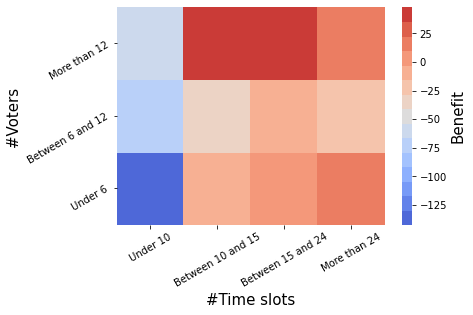

In [6]:
df1 =  df.pivot('num_voters','num_ts','a10-a01')
f = plt.figure()
ax=sns.heatmap(df1, cmap=sns.color_palette("coolwarm", 15), cbar_kws={'label': 'Benefit'})
ax.set_ylabel("#Voters ",fontsize=15)
ax.set_xlabel("#Time slots",fontsize=15)
ax.set(xticklabels=['Under 10','Between 10 and 15', 'Between 15 and 24', 'More than 24'])
ax.set_xticklabels(labels=['Under 10','Between 10 and 15', 'Between 15 and 24', 'More than 24'], rotation=30)
ax.set_yticklabels(labels=['Under 6','Between 6 and 12', 'More than 12'], rotation=30)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.invert_yaxis()

# f.savefig("Errors delta_hat2.png", bbox_inches='tight', dpi=600)

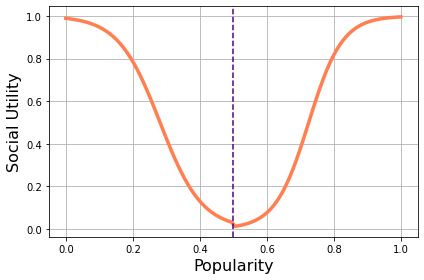

In [7]:
# Visualize su_pop
x = np.linspace(0,1,100)
y = [su_pop(x[i], 1) for i in range(100)]
f=plt.figure()
ax = sns.lineplot(x=x, y=y, color='coral', linewidth=3.5)
plt.grid()
plt.xlabel('Popularity', fontsize=16); 
plt.ylabel('Social Utility', fontsize=16);
plt.axvline([0.5], color='indigo', linestyle='--')
plt.tight_layout()

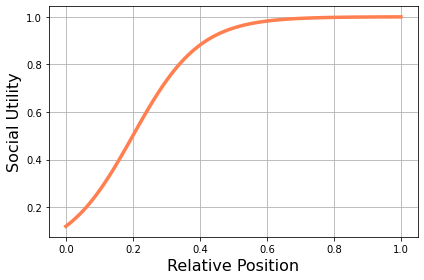

In [8]:
# Visualize su_n
x = np.linspace(0,1,100)
y = expit(10*(x)-2)
f=plt.figure()
ax = sns.lineplot(x=x, y=y, color='coral', linewidth=3.5)
plt.grid()
plt.xlabel('Relative Position', fontsize=16); 
plt.ylabel('Social Utility', fontsize=16);
plt.tight_layout()